In [1]:
import pandas as pd

df = pd.read_excel('OnlineRetail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [14]:
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
daily_sales = df.groupby('InvoiceDate').agg({'Quantity': 'sum'}).reset_index()
daily_sales.set_index('InvoiceDate', inplace=True)
daily_sales = daily_sales.asfreq('D')
daily_sales['Quantity'] = daily_sales['Quantity'].fillna(method='ffill')
daily_sales.head()


,Quantity
InvoiceDate,
2010-12-01 08:26:00,40.0
2010-12-02 08:26:00,40.0
2010-12-03 08:26:00,40.0
2010-12-04 08:26:00,40.0
2010-12-05 08:26:00,40.0


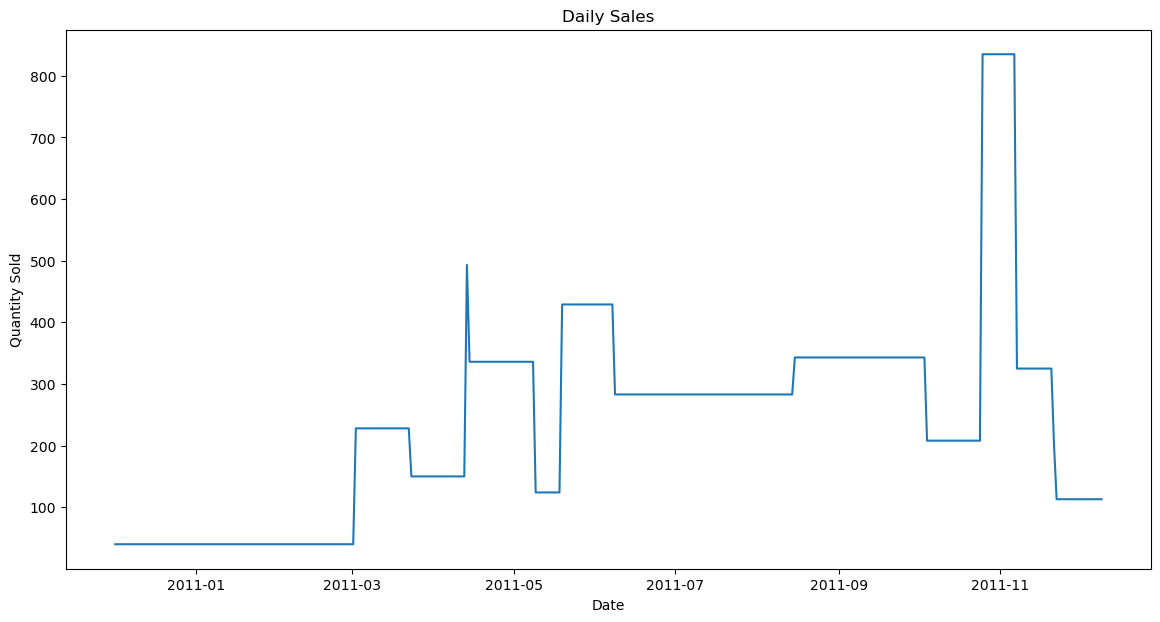

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(daily_sales)
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()


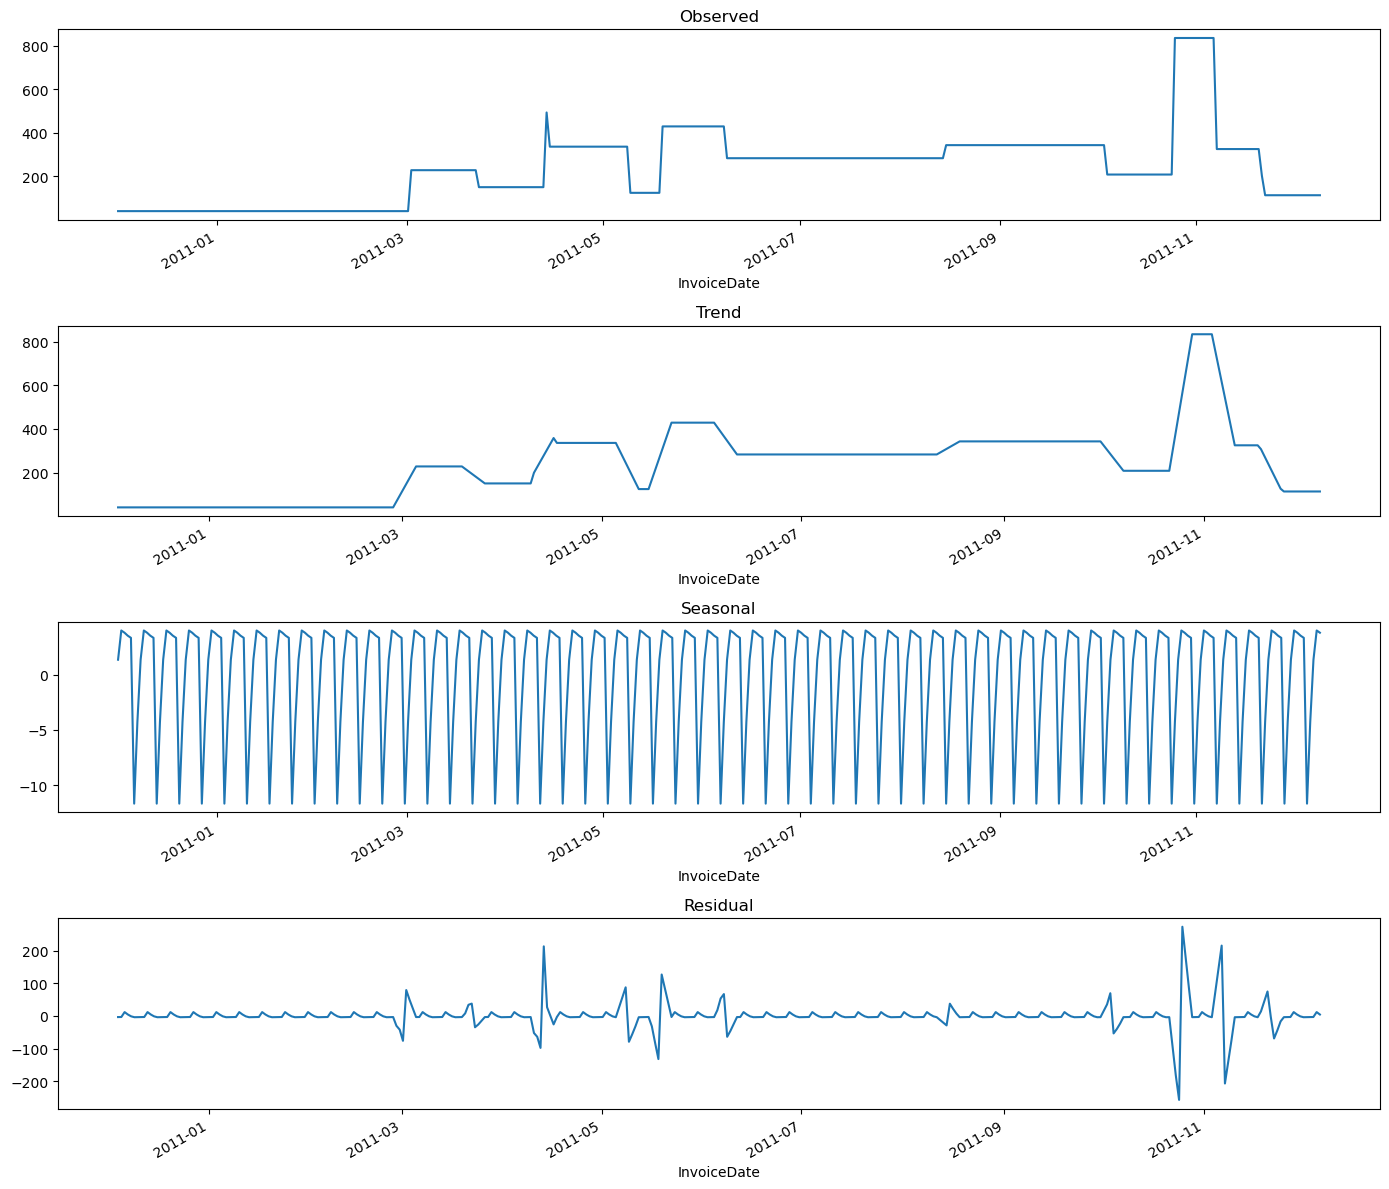

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_sales, model='additive', period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()


In [18]:
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales.iloc[:train_size], daily_sales.iloc[train_size:]
print(f'Training set length: {len(train)}')
print(f'Testing set length: {len(test)}')


Training set length: 299
Testing set length: 75


In [21]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train, seasonal=True, m=7)
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1470.893
Date:                Sun, 30 Jun 2024   AIC                           2945.786
Time:                        14:31:22   BIC                           2953.180
Sample:                    12-01-2010   HQIC                          2948.746
                         - 09-25-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1588      0.029     -5.507      0.000      -0.215      -0.102
sigma2      1134.3293     15.979     70.990      0.000    1103.012    1165.647
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [27]:
arima_model = ARIMA(train, order=model.order)
arima_model_fit = arima_model.fit()

forecast = arima_model_fit.forecast(steps=len(test))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Forecast'])
forecast.head()

,Forecast
InvoiceDate,
2011-09-26 08:26:00,NaN
2011-09-27 08:26:00,NaN
2011-09-28 08:26:00,NaN
2011-09-29 08:26:00,NaN
2011-09-30 08:26:00,NaN


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


ValueError: Input contains NaN.

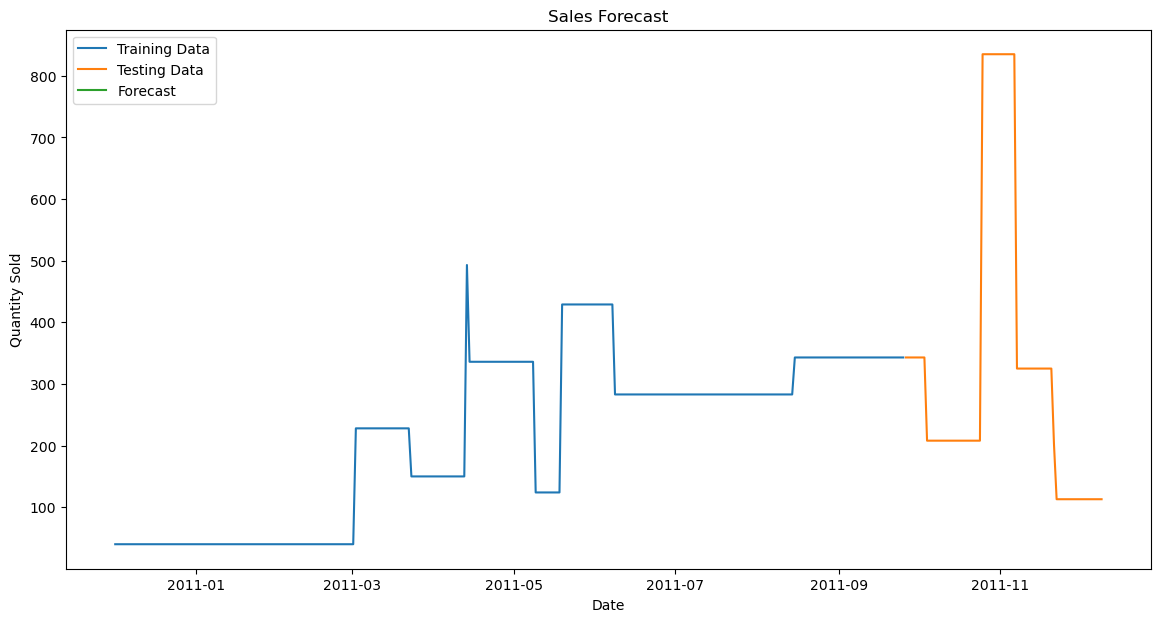

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(forecast, label='Forecast')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()
